In [1]:
pip install h3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 47.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [4]:
census_hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/census_hourly_h3.csv")
census_2hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/census_2hourly_h3.csv")
census_6hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/census_6hourly_h3.csv")
census_12hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/census_12hourly_h3.csv")

area_hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/area_hourly_h3.csv")
area_2hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/area_2hourly_h3.csv")
area_6hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/area_6hourly_h3.csv")
area_12hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/area_12hourly_h3.csv")

datasets = {
    "census_hourly_h3": census_hourly_h3,
    "census_2hourly_h3": census_2hourly_h3,
    "census_6hourly_h3": census_6hourly_h3,
    "census_12hourly_h3": census_12hourly_h3,
    "area_hourly_h3": area_hourly_h3,
    "area_2hourly_h3": area_2hourly_h3,
    "area_6hourly_h3": area_6hourly_h3,
    "area_12hourly_h3": area_12hourly_h3,
}

# 1 Feature Selection

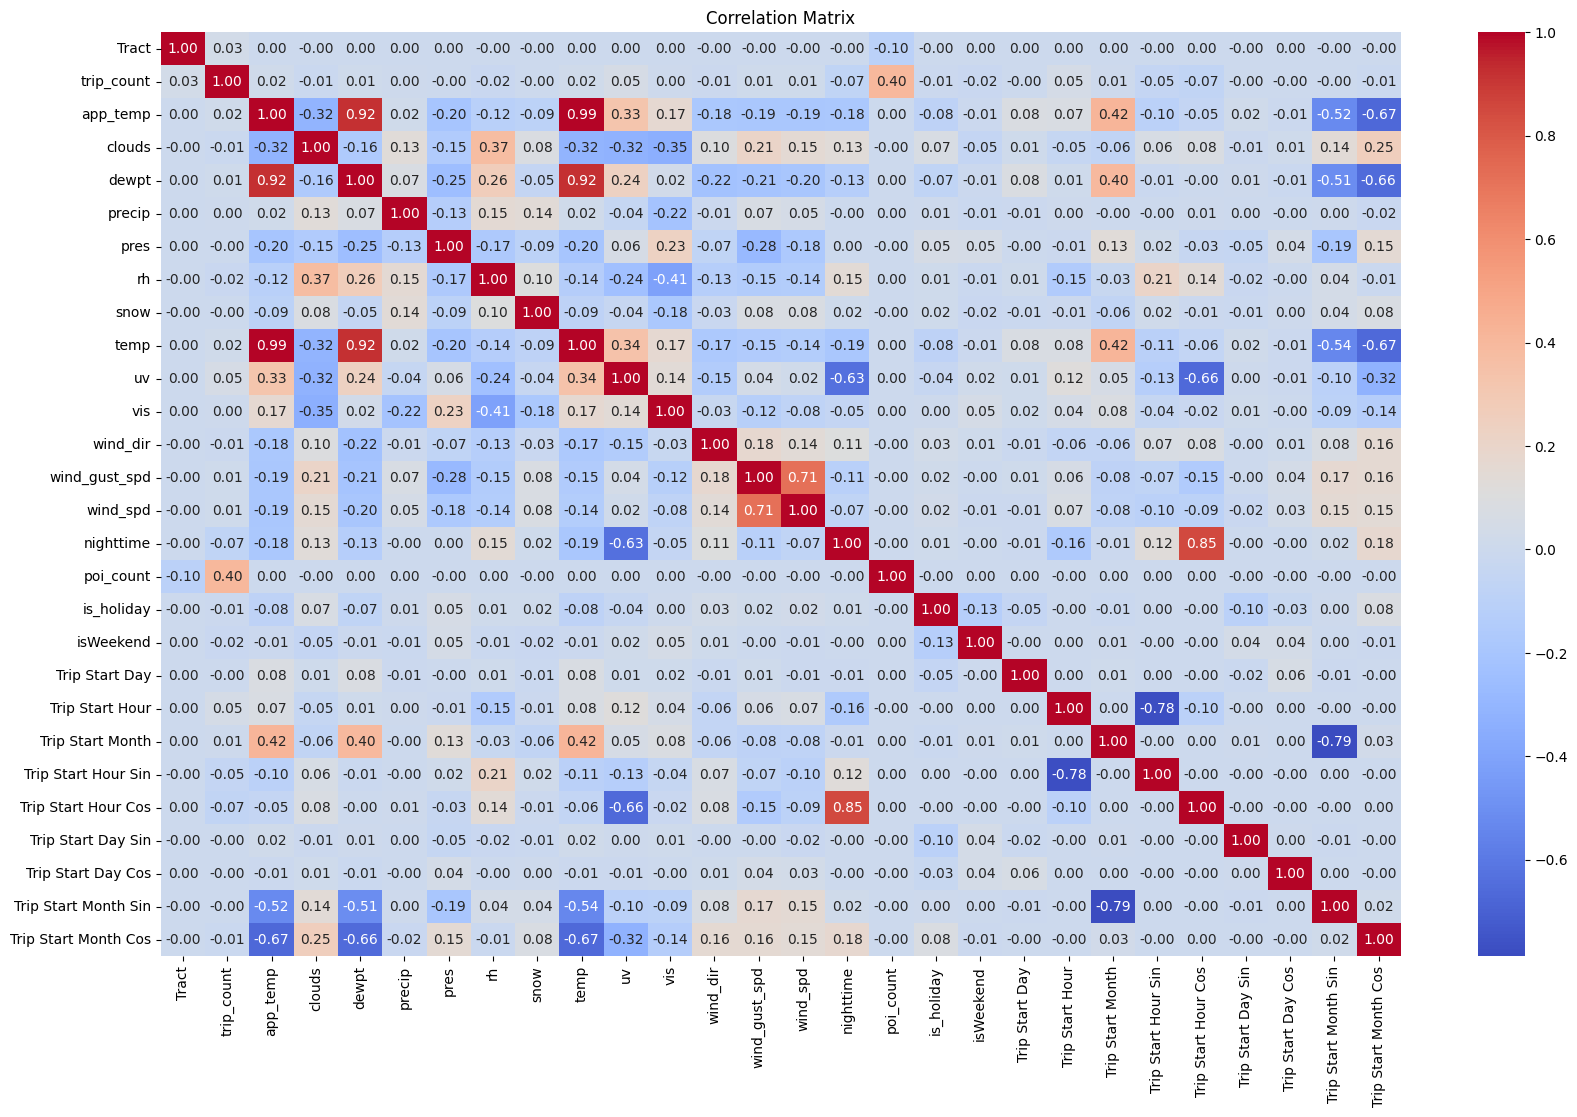

In [5]:
# corr matrix
numeric_columns = census_hourly_h3.select_dtypes(include='number')

corr_matrix = numeric_columns.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [6]:
for _, df in datasets.items():
    df.drop(columns=['dewpt', 'app_temp'], inplace = True)

In [7]:
census_hourly_h3.columns

Index(['Trip Hour', 'Tract', 'trip_count', 'Pickup Centroid Location',
       'pickup_h3_9', 'clouds', 'precip', 'pres', 'rh', 'snow', 'temp', 'uv',
       'vis', 'wind_dir', 'wind_gust_spd', 'wind_spd', 'nighttime',
       'poi_count', 'is_holiday', 'isWeekend', 'Trip Start Day',
       'Trip Start Hour', 'Trip Start Month', 'Trip Start Hour Sin',
       'Trip Start Hour Cos', 'Trip Start Day Sin', 'Trip Start Day Cos',
       'Trip Start Month Sin', 'Trip Start Month Cos'],
      dtype='object')

# 2. DNN Architectures

In [8]:
class TripDataset(Dataset):
    def __init__(self, X_num, X_cat, y):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]


In [9]:
class BaseNet(nn.Module):
    def __init__(self, input_dim, h3_vocab_size, h3_emb_dim, hidden_dims):
        super().__init__()
        self.embedding = nn.Embedding(h3_vocab_size, h3_emb_dim)
        self.input_layer = nn.Linear(input_dim + h3_emb_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList(
            nn.Linear(in_dim, out_dim)
            for in_dim, out_dim in zip(hidden_dims[:-1], hidden_dims[1:])
        )
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.activation = nn.ReLU()

    def forward(self, x_num, x_cat):
        x_cat_emb = self.embedding(x_cat)
        x = torch.cat([x_num, x_cat_emb], dim=1)
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output_layer(x)


In [10]:
def get_model(model_type, input_dim, h3_vocab_size):
    if model_type == "simple":
        return BaseNet(input_dim, h3_vocab_size, h3_emb_dim=8, hidden_dims=[32])
    elif model_type == "medium":
        return BaseNet(input_dim, h3_vocab_size, h3_emb_dim=16, hidden_dims=[64, 32])
    elif model_type == "deep":
        return BaseNet(input_dim, h3_vocab_size, h3_emb_dim=32, hidden_dims=[128, 64, 32])
    else:
        raise ValueError("Invalid model type")


In [11]:
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, title="Model Training"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_num, X_cat, y in train_loader:
            X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X_num, X_cat)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(y)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluation phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_num, X_cat, y in test_loader:
                X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)
                output = model(X_num, X_cat)
                loss = criterion(output, y)
                test_loss += loss.item() * len(y)

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

    # Plotting the loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'{title} Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
def evaluate_model(model, data_loader):
    model.eval()
    device = next(model.parameters()).device
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for X_num, X_cat, y in data_loader:
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            output = model(X_num, X_cat).cpu().numpy()
            y_true_all.extend(y.numpy())
            y_pred_all.extend(output)

    y_true_all = np.array(y_true_all).flatten()
    y_pred_all = np.array(y_pred_all).flatten()

    mape = np.mean(np.abs((y_true_all - y_pred_all) / (y_true_all + 1e-8))) * 100

    return {
        "MSE": mean_squared_error(y_true_all, y_pred_all),
        "MAE": mean_absolute_error(y_true_all, y_pred_all),
        "R2": r2_score(y_true_all, y_pred_all),
        "MAPE":mape
    }



Training SIMPLE model on census_hourly_h3...
Epoch 1: Train Loss = 8.8280, Test Loss = 6.9819
Epoch 2: Train Loss = 6.6694, Test Loss = 6.2607
Epoch 3: Train Loss = 6.1139, Test Loss = 5.7310
Epoch 4: Train Loss = 5.8192, Test Loss = 5.6869
Epoch 5: Train Loss = 5.6454, Test Loss = 5.3721
Epoch 6: Train Loss = 5.4932, Test Loss = 5.6099
Epoch 7: Train Loss = 5.3758, Test Loss = 5.2738
Epoch 8: Train Loss = 5.2876, Test Loss = 5.1748
Epoch 9: Train Loss = 5.2203, Test Loss = 5.0732
Epoch 10: Train Loss = 5.1656, Test Loss = 4.8943


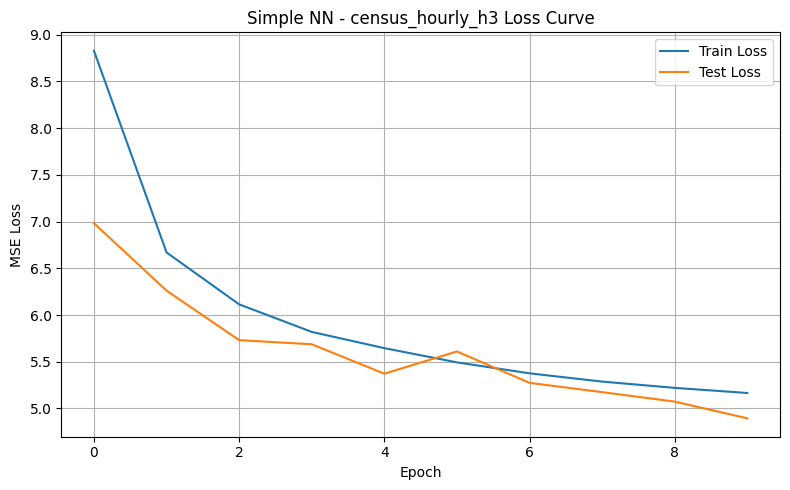


Training MEDIUM model on census_hourly_h3...
Epoch 1: Train Loss = 6.2991, Test Loss = 4.4614
Epoch 2: Train Loss = 4.5346, Test Loss = 4.6400
Epoch 3: Train Loss = 4.1756, Test Loss = 4.0028
Epoch 4: Train Loss = 3.9790, Test Loss = 3.6236
Epoch 5: Train Loss = 3.8538, Test Loss = 3.5734
Epoch 6: Train Loss = 3.7562, Test Loss = 3.5787
Epoch 7: Train Loss = 3.6755, Test Loss = 3.4070
Epoch 8: Train Loss = 3.6041, Test Loss = 3.3801
Epoch 9: Train Loss = 3.5435, Test Loss = 3.5244
Epoch 10: Train Loss = 3.4679, Test Loss = 3.3206


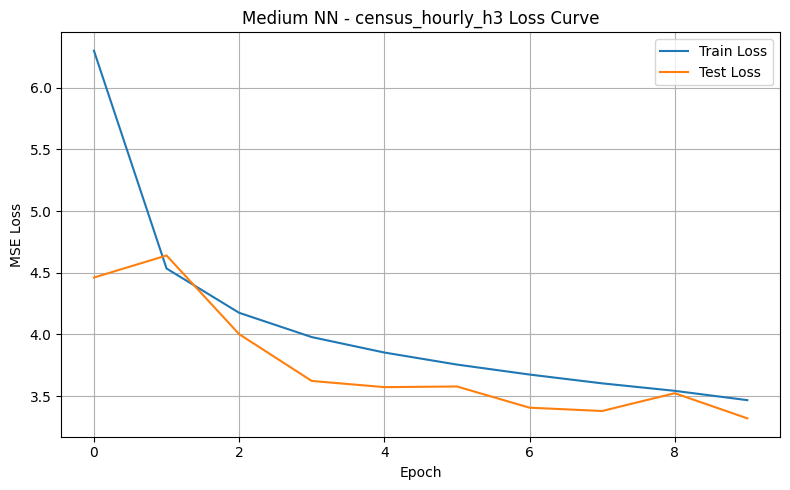


Training DEEP model on census_hourly_h3...
Epoch 1: Train Loss = 5.8093, Test Loss = 4.8329
Epoch 2: Train Loss = 4.3352, Test Loss = 3.8843
Epoch 3: Train Loss = 3.9842, Test Loss = 4.1399
Epoch 4: Train Loss = 3.7861, Test Loss = 3.6251
Epoch 5: Train Loss = 3.6590, Test Loss = 3.4277
Epoch 6: Train Loss = 3.5570, Test Loss = 3.3631
Epoch 7: Train Loss = 3.4422, Test Loss = 3.5895
Epoch 8: Train Loss = 3.3826, Test Loss = 3.2577
Epoch 9: Train Loss = 3.2890, Test Loss = 3.1668
Epoch 10: Train Loss = 3.2048, Test Loss = 3.0928


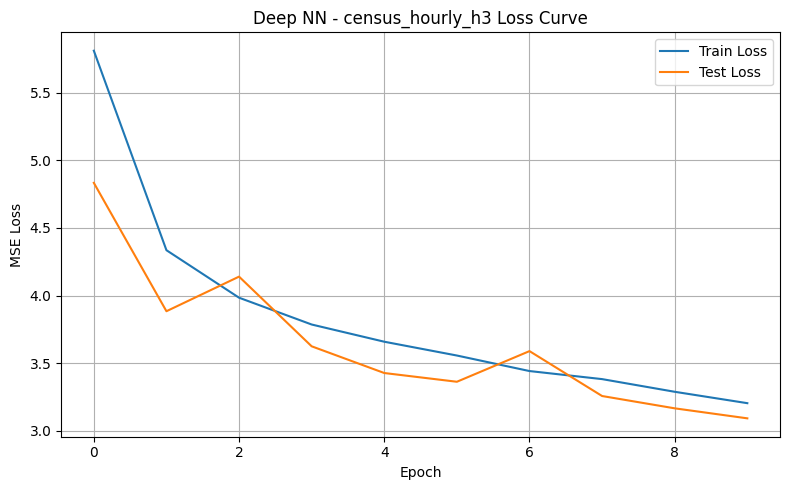


Training SIMPLE model on census_2hourly_h3...
Epoch 1: Train Loss = 39.9570, Test Loss = 27.4611
Epoch 2: Train Loss = 26.8479, Test Loss = 24.8446
Epoch 3: Train Loss = 25.1399, Test Loss = 23.6636
Epoch 4: Train Loss = 24.1957, Test Loss = 23.0316
Epoch 5: Train Loss = 23.5128, Test Loss = 22.4450
Epoch 6: Train Loss = 22.9480, Test Loss = 21.7410
Epoch 7: Train Loss = 22.3256, Test Loss = 21.0892
Epoch 8: Train Loss = 21.3923, Test Loss = 20.0724
Epoch 9: Train Loss = 20.6475, Test Loss = 19.4277
Epoch 10: Train Loss = 20.0530, Test Loss = 18.9249


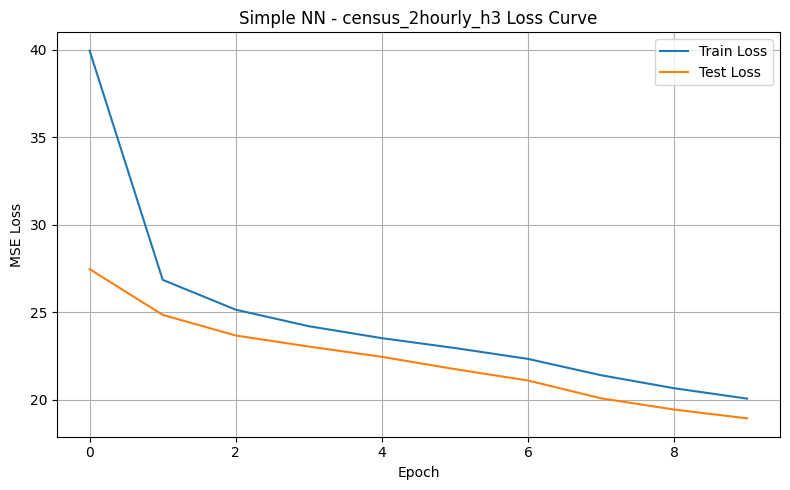


Training MEDIUM model on census_2hourly_h3...
Epoch 1: Train Loss = 27.8749, Test Loss = 19.0646
Epoch 2: Train Loss = 18.0458, Test Loss = 15.9191
Epoch 3: Train Loss = 16.3241, Test Loss = 15.1454
Epoch 4: Train Loss = 15.5000, Test Loss = 14.4992
Epoch 5: Train Loss = 14.8513, Test Loss = 14.9233
Epoch 6: Train Loss = 14.3386, Test Loss = 14.3287
Epoch 7: Train Loss = 14.0203, Test Loss = 12.9727
Epoch 8: Train Loss = 13.6560, Test Loss = 13.8005
Epoch 9: Train Loss = 13.3702, Test Loss = 12.7000
Epoch 10: Train Loss = 13.1483, Test Loss = 13.4256


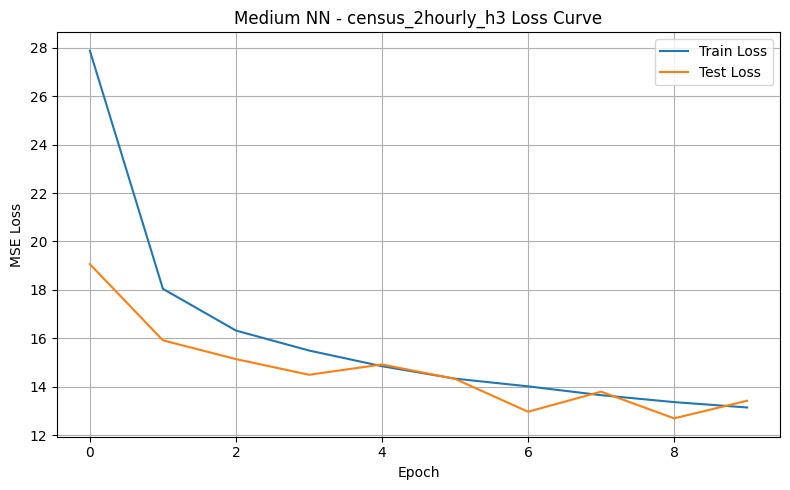


Training DEEP model on census_2hourly_h3...
Epoch 1: Train Loss = 23.8793, Test Loss = 17.5526
Epoch 2: Train Loss = 16.8060, Test Loss = 14.8213
Epoch 3: Train Loss = 15.1564, Test Loss = 13.4278
Epoch 4: Train Loss = 14.2786, Test Loss = 12.6447
Epoch 5: Train Loss = 13.6581, Test Loss = 13.3703
Epoch 6: Train Loss = 12.9872, Test Loss = 13.1097
Epoch 7: Train Loss = 12.7231, Test Loss = 12.5790
Epoch 8: Train Loss = 12.3986, Test Loss = 11.8363
Epoch 9: Train Loss = 12.0489, Test Loss = 11.8031
Epoch 10: Train Loss = 11.7330, Test Loss = 11.3461


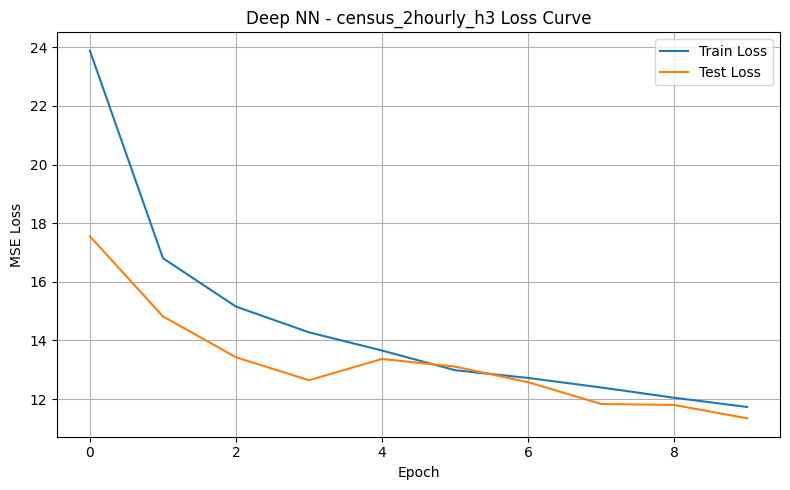


Training SIMPLE model on census_6hourly_h3...
Epoch 1: Train Loss = 452.1290, Test Loss = 267.3637
Epoch 2: Train Loss = 224.1131, Test Loss = 215.7094
Epoch 3: Train Loss = 186.2101, Test Loss = 186.7666
Epoch 4: Train Loss = 168.6037, Test Loss = 172.3399
Epoch 5: Train Loss = 158.8305, Test Loss = 166.4329
Epoch 6: Train Loss = 152.5267, Test Loss = 158.5965
Epoch 7: Train Loss = 147.5657, Test Loss = 154.5553
Epoch 8: Train Loss = 143.2397, Test Loss = 150.7679
Epoch 9: Train Loss = 139.4758, Test Loss = 147.1100
Epoch 10: Train Loss = 135.6522, Test Loss = 143.0646


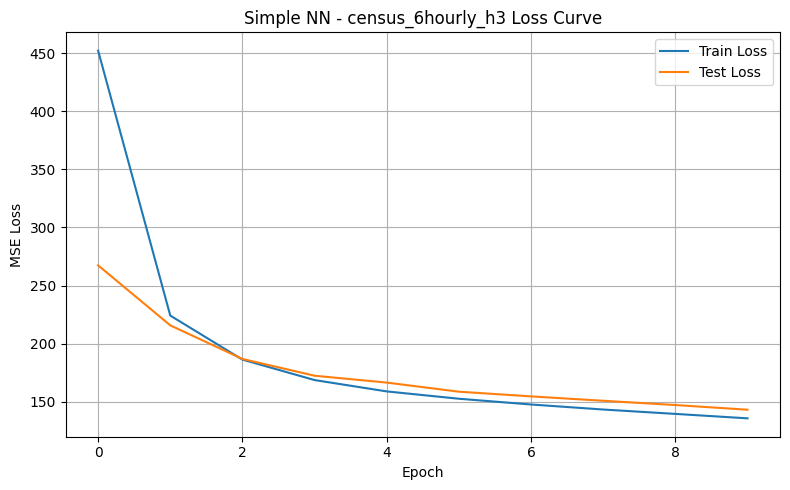


Training MEDIUM model on census_6hourly_h3...
Epoch 1: Train Loss = 276.9132, Test Loss = 152.5980
Epoch 2: Train Loss = 126.5663, Test Loss = 119.5908
Epoch 3: Train Loss = 111.3936, Test Loss = 122.6665
Epoch 4: Train Loss = 105.5160, Test Loss = 116.9265
Epoch 5: Train Loss = 102.6360, Test Loss = 107.9092
Epoch 6: Train Loss = 99.8765, Test Loss = 106.7288
Epoch 7: Train Loss = 98.3936, Test Loss = 104.5598
Epoch 8: Train Loss = 96.2820, Test Loss = 99.9178
Epoch 9: Train Loss = 93.7343, Test Loss = 105.2499
Epoch 10: Train Loss = 93.0632, Test Loss = 100.6256


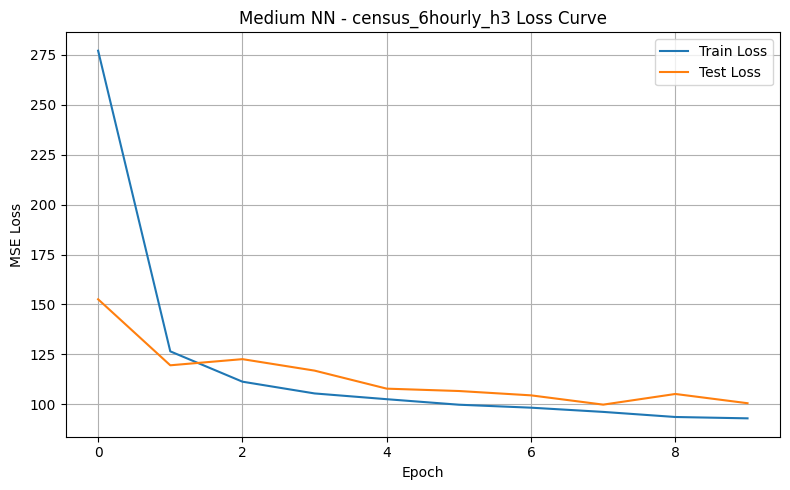


Training DEEP model on census_6hourly_h3...
Epoch 1: Train Loss = 194.8248, Test Loss = 120.6195
Epoch 2: Train Loss = 114.6665, Test Loss = 103.3814
Epoch 3: Train Loss = 106.2857, Test Loss = 107.4746
Epoch 4: Train Loss = 101.7613, Test Loss = 117.3736
Epoch 5: Train Loss = 96.9928, Test Loss = 97.6643
Epoch 6: Train Loss = 93.1159, Test Loss = 139.1673
Epoch 7: Train Loss = 91.7502, Test Loss = 100.9505
Epoch 8: Train Loss = 89.7881, Test Loss = 90.5203
Epoch 9: Train Loss = 87.9354, Test Loss = 95.1125
Epoch 10: Train Loss = 85.6721, Test Loss = 98.9006


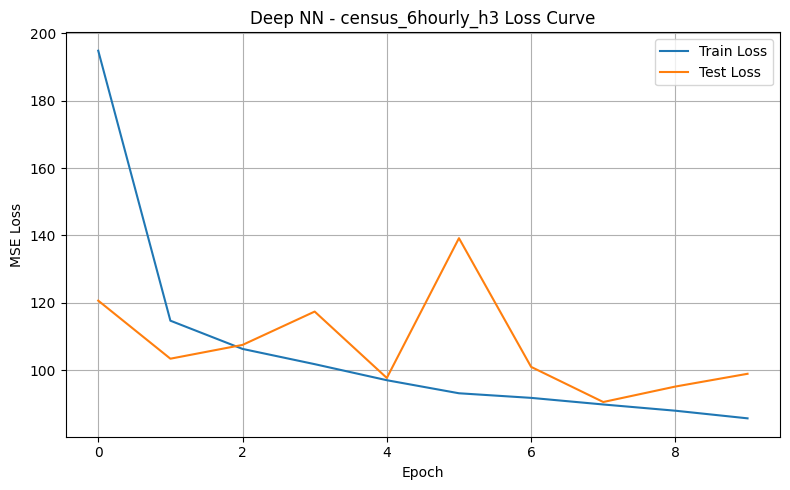


Training SIMPLE model on census_12hourly_h3...
Epoch 1: Train Loss = 2186.1172, Test Loss = 1115.7972
Epoch 2: Train Loss = 891.2251, Test Loss = 731.9707
Epoch 3: Train Loss = 676.3475, Test Loss = 610.6114
Epoch 4: Train Loss = 588.6759, Test Loss = 542.2454
Epoch 5: Train Loss = 536.9411, Test Loss = 503.5291
Epoch 6: Train Loss = 500.8662, Test Loss = 473.9351
Epoch 7: Train Loss = 473.9581, Test Loss = 447.5502
Epoch 8: Train Loss = 451.7463, Test Loss = 428.3016
Epoch 9: Train Loss = 434.5959, Test Loss = 417.0984
Epoch 10: Train Loss = 422.3136, Test Loss = 404.3251


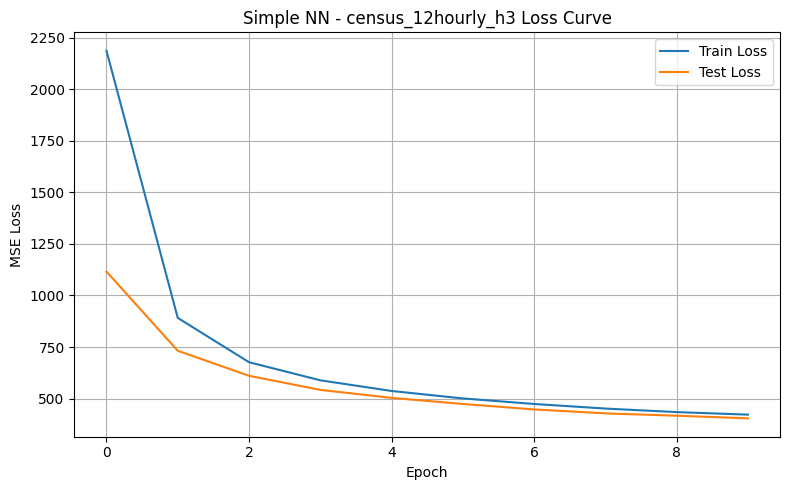


Training MEDIUM model on census_12hourly_h3...
Epoch 1: Train Loss = 1218.8316, Test Loss = 564.3724
Epoch 2: Train Loss = 497.7436, Test Loss = 418.4069
Epoch 3: Train Loss = 415.5930, Test Loss = 378.8122
Epoch 4: Train Loss = 384.5229, Test Loss = 351.2843
Epoch 5: Train Loss = 367.3691, Test Loss = 341.1036
Epoch 6: Train Loss = 357.3388, Test Loss = 333.0911
Epoch 7: Train Loss = 348.4557, Test Loss = 349.7011
Epoch 8: Train Loss = 342.9900, Test Loss = 323.7907
Epoch 9: Train Loss = 339.2442, Test Loss = 325.6263
Epoch 10: Train Loss = 332.0685, Test Loss = 321.6382


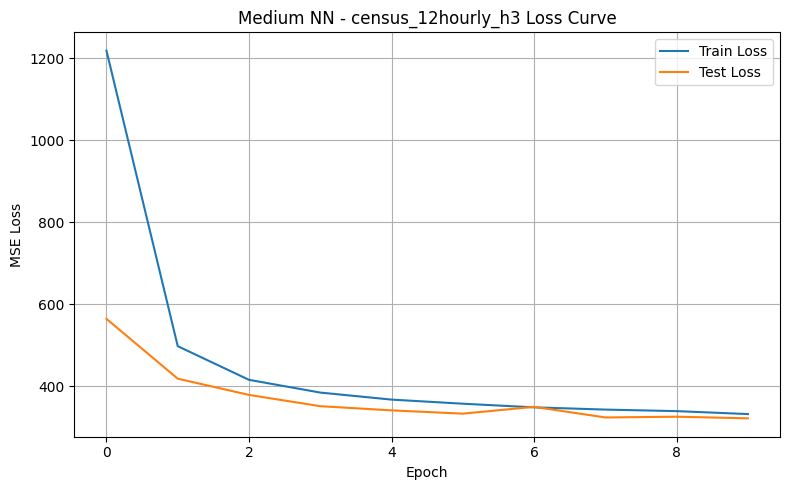


Training DEEP model on census_12hourly_h3...
Epoch 1: Train Loss = 868.8223, Test Loss = 487.2063
Epoch 2: Train Loss = 372.2621, Test Loss = 330.2275
Epoch 3: Train Loss = 351.9656, Test Loss = 329.3478
Epoch 4: Train Loss = 343.5014, Test Loss = 320.3491
Epoch 5: Train Loss = 320.0376, Test Loss = 355.9064
Epoch 6: Train Loss = 321.4661, Test Loss = 341.7495
Epoch 7: Train Loss = 312.9318, Test Loss = 303.6961
Epoch 8: Train Loss = 303.8905, Test Loss = 302.0205
Epoch 9: Train Loss = 303.1024, Test Loss = 323.2629
Epoch 10: Train Loss = 293.4717, Test Loss = 372.0903


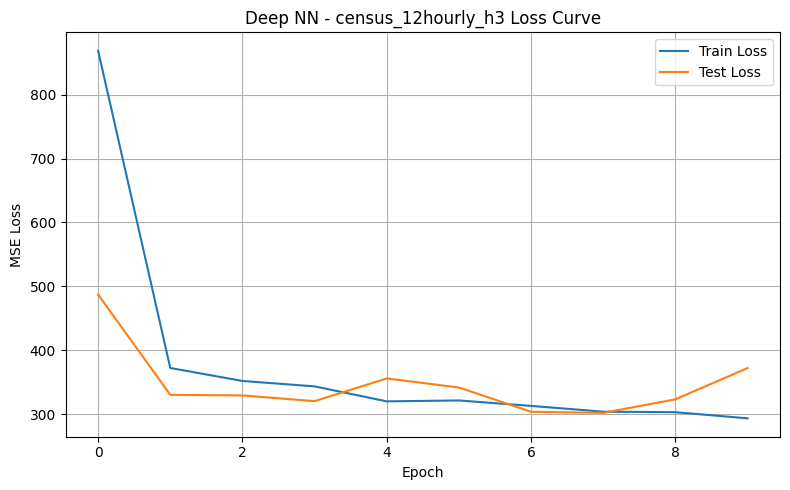


Training SIMPLE model on area_hourly_h3...
Epoch 1: Train Loss = 932.7945, Test Loss = 470.9087
Epoch 2: Train Loss = 412.8116, Test Loss = 371.8546
Epoch 3: Train Loss = 354.2888, Test Loss = 331.9170
Epoch 4: Train Loss = 321.2366, Test Loss = 304.5742
Epoch 5: Train Loss = 296.2604, Test Loss = 280.8642
Epoch 6: Train Loss = 277.8118, Test Loss = 265.6507
Epoch 7: Train Loss = 264.6894, Test Loss = 253.4650
Epoch 8: Train Loss = 255.2213, Test Loss = 246.9725
Epoch 9: Train Loss = 248.2599, Test Loss = 240.7991
Epoch 10: Train Loss = 242.6289, Test Loss = 234.0589


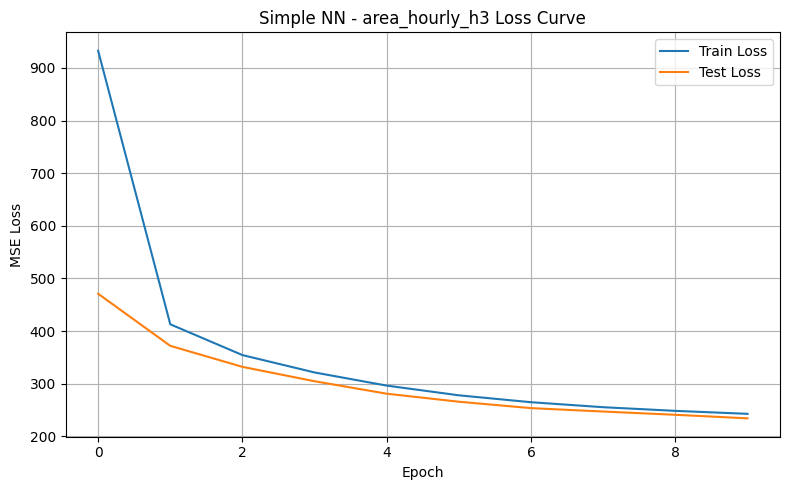


Training MEDIUM model on area_hourly_h3...
Epoch 1: Train Loss = 531.4664, Test Loss = 268.0057
Epoch 2: Train Loss = 256.6393, Test Loss = 232.7692
Epoch 3: Train Loss = 227.6990, Test Loss = 211.0207
Epoch 4: Train Loss = 207.1008, Test Loss = 192.1608
Epoch 5: Train Loss = 193.6858, Test Loss = 203.1646
Epoch 6: Train Loss = 184.9332, Test Loss = 176.9398
Epoch 7: Train Loss = 178.2889, Test Loss = 168.9045
Epoch 8: Train Loss = 173.0581, Test Loss = 169.6149
Epoch 9: Train Loss = 170.2170, Test Loss = 163.9742
Epoch 10: Train Loss = 166.8123, Test Loss = 164.9225


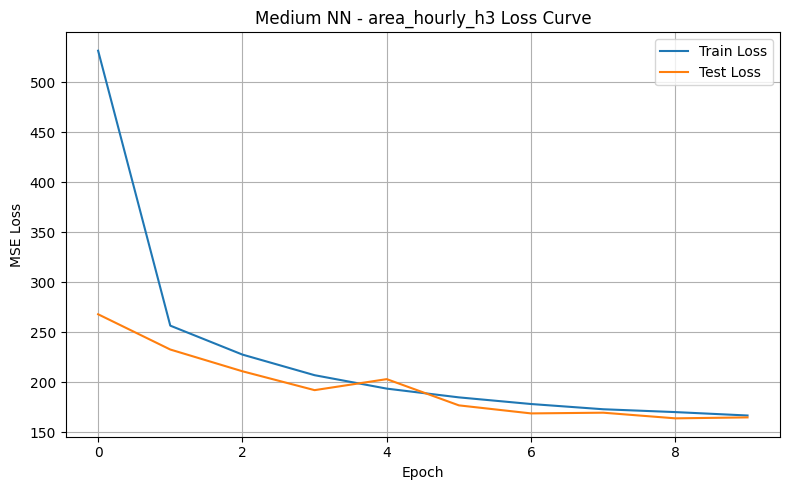


Training DEEP model on area_hourly_h3...
Epoch 1: Train Loss = 407.8070, Test Loss = 222.7043
Epoch 2: Train Loss = 211.1821, Test Loss = 182.8980
Epoch 3: Train Loss = 188.6188, Test Loss = 181.4030
Epoch 4: Train Loss = 175.4839, Test Loss = 168.7419
Epoch 5: Train Loss = 167.5637, Test Loss = 155.4086
Epoch 6: Train Loss = 162.0922, Test Loss = 156.1606
Epoch 7: Train Loss = 158.6069, Test Loss = 158.4813
Epoch 8: Train Loss = 155.9911, Test Loss = 151.6561
Epoch 9: Train Loss = 153.4976, Test Loss = 145.6931
Epoch 10: Train Loss = 150.7751, Test Loss = 140.4819


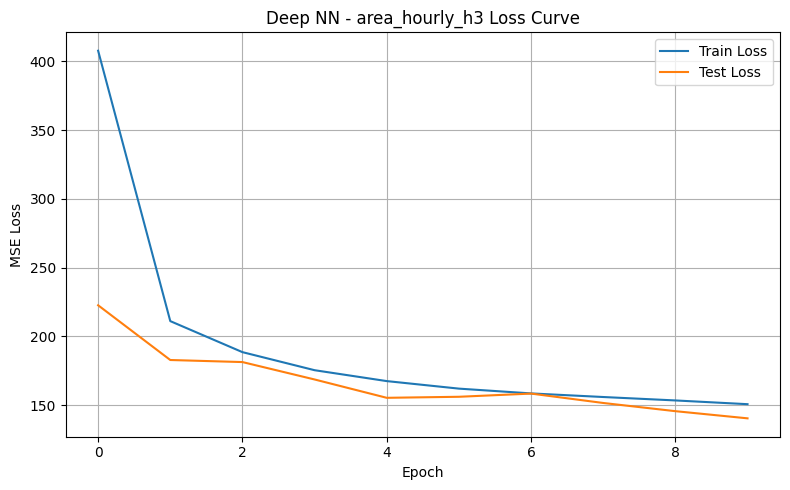


Training SIMPLE model on area_2hourly_h3...
Epoch 1: Train Loss = 4412.4560, Test Loss = 2182.7524
Epoch 2: Train Loss = 1725.2687, Test Loss = 1478.9463
Epoch 3: Train Loss = 1304.6016, Test Loss = 1241.4074
Epoch 4: Train Loss = 1145.7947, Test Loss = 1135.1849
Epoch 5: Train Loss = 1062.2511, Test Loss = 1063.7027
Epoch 6: Train Loss = 1000.3542, Test Loss = 1015.9100
Epoch 7: Train Loss = 951.4125, Test Loss = 964.9554
Epoch 8: Train Loss = 912.2088, Test Loss = 929.8505
Epoch 9: Train Loss = 881.2226, Test Loss = 905.3359
Epoch 10: Train Loss = 855.1248, Test Loss = 875.1282


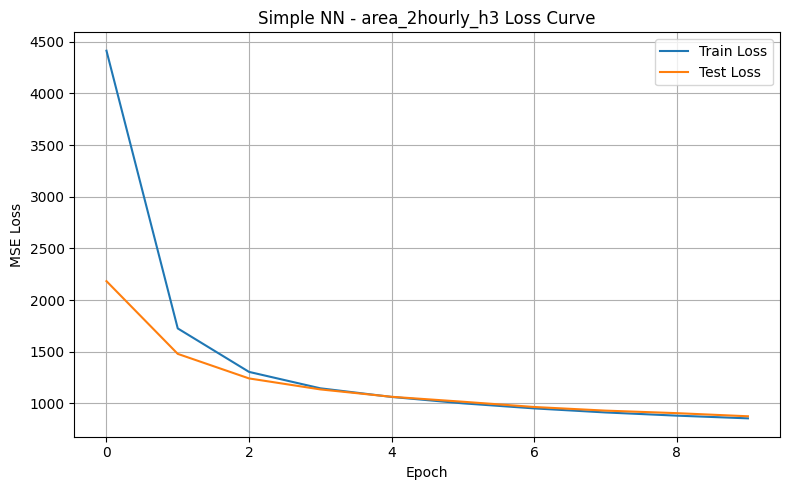


Training MEDIUM model on area_2hourly_h3...
Epoch 1: Train Loss = 2484.9620, Test Loss = 1127.8963
Epoch 2: Train Loss = 946.2133, Test Loss = 865.0618
Epoch 3: Train Loss = 786.6617, Test Loss = 791.0204
Epoch 4: Train Loss = 716.7485, Test Loss = 708.1900
Epoch 5: Train Loss = 677.4651, Test Loss = 659.3464
Epoch 6: Train Loss = 640.9221, Test Loss = 629.3907
Epoch 7: Train Loss = 614.9800, Test Loss = 629.7922
Epoch 8: Train Loss = 592.2984, Test Loss = 588.4697
Epoch 9: Train Loss = 572.8897, Test Loss = 559.6670
Epoch 10: Train Loss = 555.9842, Test Loss = 551.8194


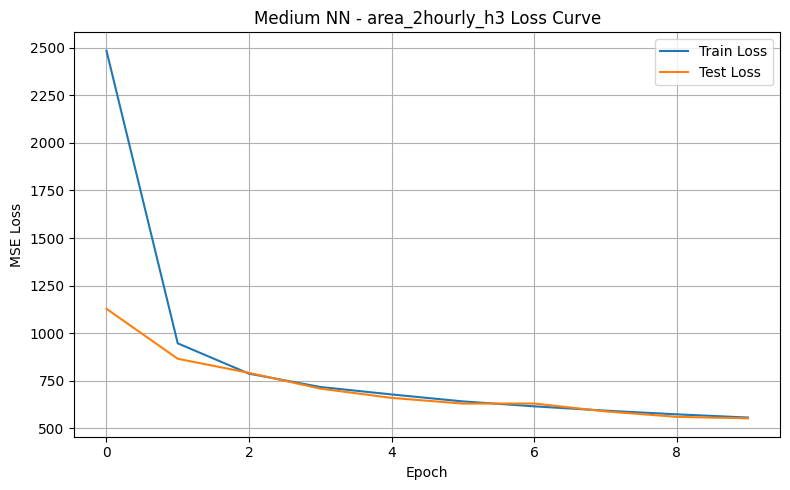


Training DEEP model on area_2hourly_h3...
Epoch 1: Train Loss = 1655.6869, Test Loss = 808.3678
Epoch 2: Train Loss = 726.8852, Test Loss = 685.3964
Epoch 3: Train Loss = 654.5532, Test Loss = 682.6373
Epoch 4: Train Loss = 597.0905, Test Loss = 571.4562
Epoch 5: Train Loss = 560.2012, Test Loss = 533.5997
Epoch 6: Train Loss = 538.0670, Test Loss = 567.4319
Epoch 7: Train Loss = 514.0484, Test Loss = 523.6021
Epoch 8: Train Loss = 497.1627, Test Loss = 525.9370
Epoch 9: Train Loss = 492.1199, Test Loss = 487.3861
Epoch 10: Train Loss = 478.8409, Test Loss = 494.8300


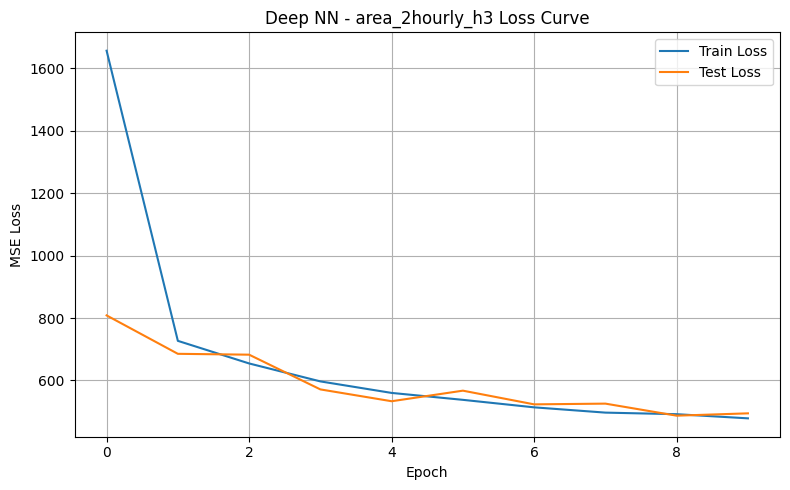


Training SIMPLE model on area_6hourly_h3...
Epoch 1: Train Loss = 48825.3817, Test Loss = 39369.1170
Epoch 2: Train Loss = 27417.1894, Test Loss = 18164.2173
Epoch 3: Train Loss = 14825.6532, Test Loss = 12362.9624
Epoch 4: Train Loss = 11665.3170, Test Loss = 10546.5815
Epoch 5: Train Loss = 10258.7215, Test Loss = 9455.8344
Epoch 6: Train Loss = 9279.6876, Test Loss = 8605.4443
Epoch 7: Train Loss = 8504.2580, Test Loss = 7928.1993
Epoch 8: Train Loss = 7880.6133, Test Loss = 7373.8982
Epoch 9: Train Loss = 7357.3167, Test Loss = 6904.7780
Epoch 10: Train Loss = 6932.2544, Test Loss = 6533.6094


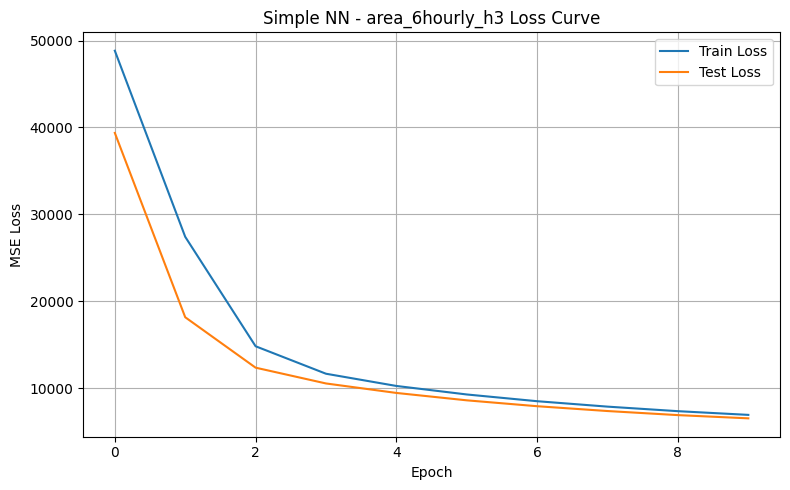


Training MEDIUM model on area_6hourly_h3...
Epoch 1: Train Loss = 29331.5155, Test Loss = 10562.7639
Epoch 2: Train Loss = 8741.2026, Test Loss = 6794.9255
Epoch 3: Train Loss = 6268.0628, Test Loss = 5543.9007
Epoch 4: Train Loss = 5305.8296, Test Loss = 4776.6264
Epoch 5: Train Loss = 4687.7187, Test Loss = 4206.0565
Epoch 6: Train Loss = 4201.0475, Test Loss = 3772.8734
Epoch 7: Train Loss = 3798.3515, Test Loss = 3493.0864
Epoch 8: Train Loss = 3529.4903, Test Loss = 3342.7027
Epoch 9: Train Loss = 3382.2360, Test Loss = 3232.6118
Epoch 10: Train Loss = 3290.9839, Test Loss = 3144.5334


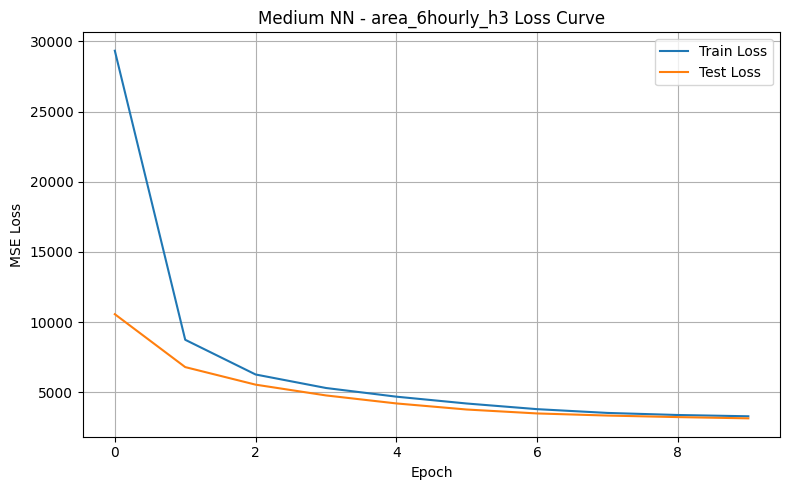


Training DEEP model on area_6hourly_h3...
Epoch 1: Train Loss = 19506.2058, Test Loss = 5981.2950
Epoch 2: Train Loss = 5072.6083, Test Loss = 3824.5765
Epoch 3: Train Loss = 3848.4110, Test Loss = 3477.2728
Epoch 4: Train Loss = 3436.6302, Test Loss = 3155.8269
Epoch 5: Train Loss = 3247.5372, Test Loss = 3105.8151
Epoch 6: Train Loss = 3119.0444, Test Loss = 3008.4375
Epoch 7: Train Loss = 3114.2924, Test Loss = 2930.3176
Epoch 8: Train Loss = 2988.1988, Test Loss = 3028.3675
Epoch 9: Train Loss = 2947.9656, Test Loss = 2988.1700
Epoch 10: Train Loss = 2943.0053, Test Loss = 2967.6163


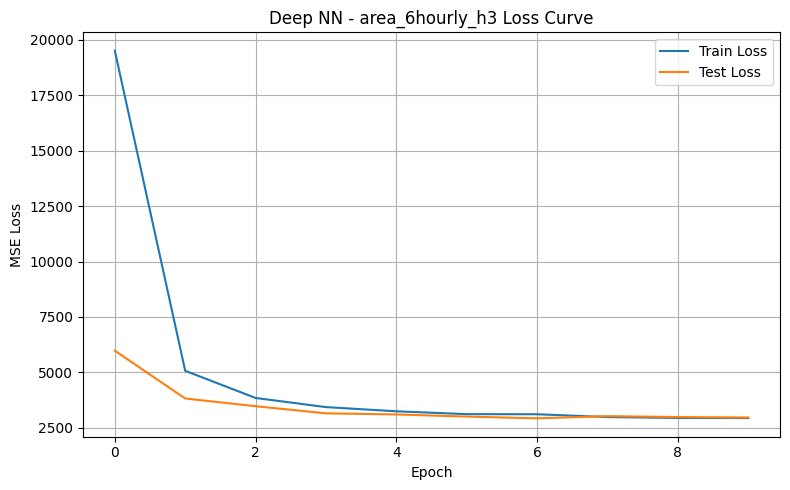


Training SIMPLE model on area_12hourly_h3...
Epoch 1: Train Loss = 169846.2441, Test Loss = 148194.8693
Epoch 2: Train Loss = 147387.6364, Test Loss = 121217.0474
Epoch 3: Train Loss = 108882.3928, Test Loss = 80715.7321
Epoch 4: Train Loss = 70429.3542, Test Loss = 52940.2262
Epoch 5: Train Loss = 49630.5926, Test Loss = 41037.6256
Epoch 6: Train Loss = 40410.9946, Test Loss = 35492.0160
Epoch 7: Train Loss = 35699.0960, Test Loss = 32082.1001
Epoch 8: Train Loss = 32599.2812, Test Loss = 29680.5677
Epoch 9: Train Loss = 30338.0352, Test Loss = 27973.9029
Epoch 10: Train Loss = 28639.0340, Test Loss = 26606.4425


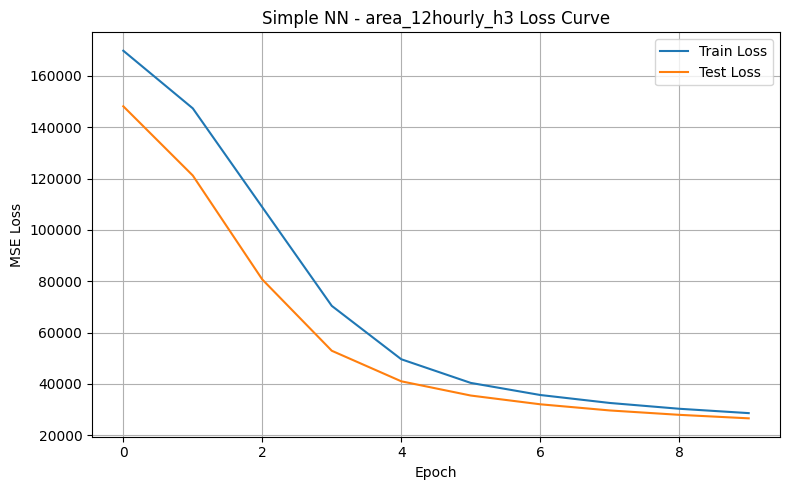


Training MEDIUM model on area_12hourly_h3...
Epoch 1: Train Loss = 145780.9016, Test Loss = 71789.3086
Epoch 2: Train Loss = 39193.9585, Test Loss = 26522.6959
Epoch 3: Train Loss = 24944.6027, Test Loss = 22486.8167
Epoch 4: Train Loss = 21240.9063, Test Loss = 19040.9641
Epoch 5: Train Loss = 18475.4151, Test Loss = 16689.1399
Epoch 6: Train Loss = 16259.9834, Test Loss = 14818.7629
Epoch 7: Train Loss = 14594.6022, Test Loss = 13476.1290
Epoch 8: Train Loss = 13431.0441, Test Loss = 12715.3322
Epoch 9: Train Loss = 12712.3784, Test Loss = 12032.8359
Epoch 10: Train Loss = 12096.2285, Test Loss = 11619.5338


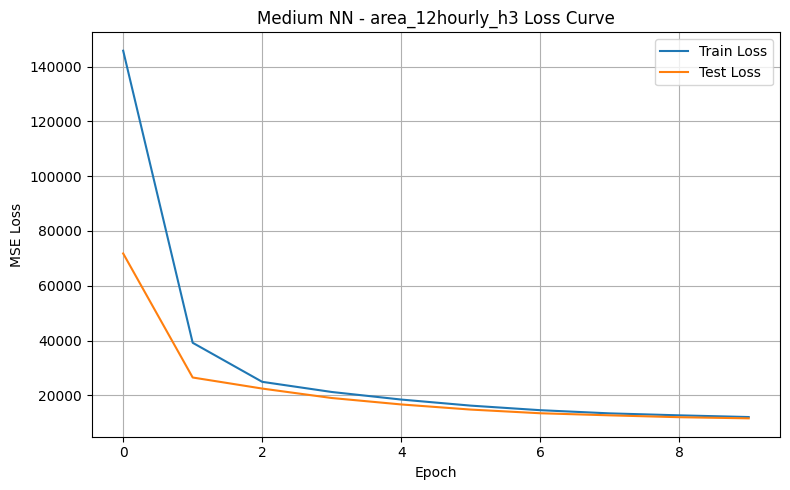


Training DEEP model on area_12hourly_h3...
Epoch 1: Train Loss = 90147.5996, Test Loss = 25034.0668
Epoch 2: Train Loss = 19844.7031, Test Loss = 14604.2840
Epoch 3: Train Loss = 12889.3276, Test Loss = 11195.9870
Epoch 4: Train Loss = 11045.9810, Test Loss = 10007.6418
Epoch 5: Train Loss = 10105.9614, Test Loss = 9460.3006
Epoch 6: Train Loss = 9338.5034, Test Loss = 9113.2078
Epoch 7: Train Loss = 9003.2159, Test Loss = 8704.3154
Epoch 8: Train Loss = 8739.8430, Test Loss = 8322.9033
Epoch 9: Train Loss = 8542.7795, Test Loss = 8834.0592
Epoch 10: Train Loss = 8324.6009, Test Loss = 8396.6549


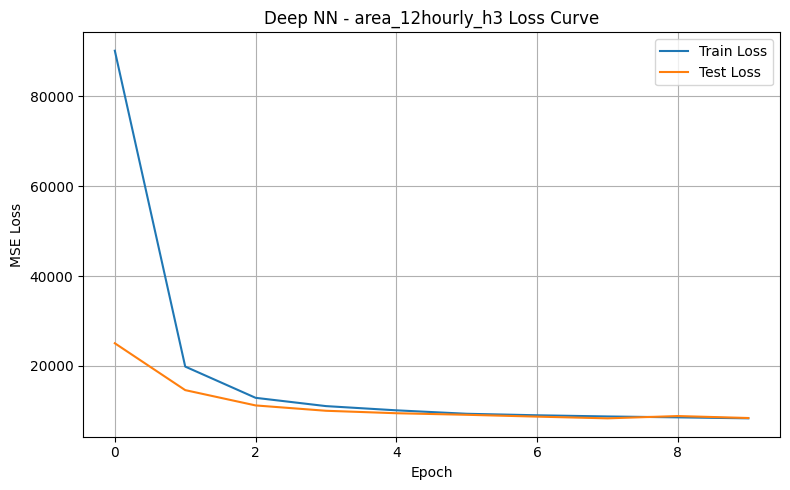

In [15]:
results = []

for name, df in datasets.items():
    df = df.copy()

    # Encode H3
    h3_encoder = LabelEncoder()
    df['h3_index'] = h3_encoder.fit_transform(df['pickup_h3_9'])

    # Select features for scaling
    scaled_features = [
        'clouds', 'precip', 'pres', 'rh', 'snow', 'temp', 'uv', 'vis',
        'wind_dir', 'wind_gust_spd', 'wind_spd', 'poi_count',
        'nighttime', 'is_holiday', 'isWeekend'
    ]
    scaler = StandardScaler()
    df[scaled_features] = scaler.fit_transform(df[scaled_features])

    # Final input features
    input_features = scaled_features + [
        'Trip Start Hour Sin', 'Trip Start Hour Cos',
        'Trip Start Day Sin', 'Trip Start Day Cos',
        'Trip Start Month Sin', 'Trip Start Month Cos',
        'Trip Start Hour', 'Trip Start Month', 'Trip Start Day'
    ]
    X_numerical = df[input_features].values
    X_h3 = df['h3_index'].values
    y = df['trip_count'].values

    # Dataset & DataLoader setup
    X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(
        X_numerical, X_h3, y, test_size=0.2, random_state=42
    )
    train_ds = TripDataset(X_train_num, X_train_cat, y_train)
    test_ds = TripDataset(X_test_num, X_test_cat, y_test)
    train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=256, num_workers=2, pin_memory=True)

    input_dim = X_numerical.shape[1]
    h3_vocab_size = len(h3_encoder.classes_)

    for complexity in ["simple", "medium", "deep"]:
        print(f"\nTraining {complexity.upper()} model on {name}...")
        model = get_model(complexity, input_dim, h3_vocab_size)
        train_model(model, train_loader, test_loader, epochs=10, title=f"{complexity.capitalize()} NN - {name}")

        metrics = evaluate_model(model, test_loader)
        metrics["Model"] = complexity.capitalize()
        metrics["Dataset"] = name
        results.append(metrics)


In [18]:
results_df = pd.DataFrame(results)
results_df = results_df[["Dataset", "Model", "MSE", "MAE", "R2"]].round(4)
print("\nFinal Model Comparison Table:")
print(results_df)

results_df.to_csv("/content/drive/MyDrive/Triple A/data/NN_commparison_table.csv")


Final Model Comparison Table:
               Dataset   Model         MSE      MAE      R2
0     census_hourly_h3  Simple      4.8943   0.4755  0.8664
1     census_hourly_h3  Medium      3.3206   0.3142  0.9094
2     census_hourly_h3    Deep      3.0928   0.3043  0.9156
3    census_2hourly_h3  Simple     18.9249   0.9318  0.8675
4    census_2hourly_h3  Medium     13.4256   0.6072  0.9060
5    census_2hourly_h3    Deep     11.3461   0.5300  0.9205
6    census_6hourly_h3  Simple    143.0646   2.6273  0.8769
7    census_6hourly_h3  Medium    100.6256   1.9896  0.9134
8    census_6hourly_h3    Deep     98.9006   1.3829  0.9149
9   census_12hourly_h3  Simple    404.3251   4.3624  0.8994
10  census_12hourly_h3  Medium    321.6382   3.2960  0.9200
11  census_12hourly_h3    Deep    372.0903   3.0307  0.9075
12      area_hourly_h3  Simple    234.0589   5.6079  0.8948
13      area_hourly_h3  Medium    164.9225   4.2772  0.9259
14      area_hourly_h3    Deep    140.4819   4.2270  0.9369
15     ar